In [592]:
import pandas as pd
from scipy.special import boxcox, inv_boxcox
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from glob import glob
import math
import pickle
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [210]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# import & prep df from 538

In [26]:
spi_url = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'
spi = pd.read_csv(spi_url)

In [27]:
spi = spi[spi['league'] == 'Barclays Premier League']

In [28]:
spi2 = spi

In [29]:
spi = spi.rename(columns={'team1':'team', 'team2': 'team_opp', 'spi1': 'spi', 'spi2': 'spi_opp', 'proj_score1': 'proj_score', 'proj_score2': 'proj_score_opp', 'prob1': 'prob_w', 'prob2': 'prob_l', 'importance1': 'importance', 'importance2': 'importance_opp'})

In [30]:
spi2 = spi2.rename(columns={'team2':'team', 'team1': 'team_opp', 'spi2': 'spi', 'spi1': 'spi_opp', 'proj_score2': 'proj_score', 'proj_score1': 'proj_score_opp', 'prob2': 'prob_w', 'prob1': 'prob_l', 'importance2': 'importance', 'importance1': 'importance_opp'})

In [31]:
spi = spi.append(spi2, sort = True)

In [32]:
spi = spi[['date', 'team', 'team_opp', 'spi', 'spi_opp', 'proj_score', 'proj_score_opp', 'prob_w', 'prob_l', 'probtie', 'importance', 'importance_opp']]

# import and append fantasy performance data

In [1205]:
#look at what columns are available

years = [('2018-19', 'ISO-8859-1'), ('2019-20', 'utf-8')]
# later realized that the 2018-19 CSV is not encoded in UTF-8, so made the above into tuples including the explicit encoding
for year, encoding in years:
    #import player-level data
    section = '/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/gws/merged_gw.csv'
    section = pd.read_csv(section, engine='python', encoding=encoding)
    print(year)
    print(list(section))

2018-19
['name', 'assists', 'attempted_passes', 'big_chances_created', 'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'clearances_blocks_interceptions', 'completed_passes', 'creativity', 'dribbles', 'ea_index', 'element', 'errors_leading_to_goal', 'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded', 'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'winning_goals', 'yellow_cards', 'GW']
2019-20
['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index

# Merge data where it's not already merged

I had to change the column names in 2018-19 teams.csv to make a column called "Team", to correspond with other seasons

In [1277]:
# I spent a long time cleaning & concatenating data from different seasons until I stumbled upon this:
# https://github.com/solpaul/fpl-prediction/blob/master/data/train_v5.csv
# thanks solpaul!

# the only thing this dataset is missing is player value on fpl, but from previous analyis, player value wasn't
# an effictive predicting feature, so I'm not worried about it for now. Can always merge it later

players = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/cleaned_data.csv', index_col = 0)

In [1278]:
players.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,14023,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,0.895471,2.243698
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,NaN,NaN,True,1,0,0,6,0,0.3,0,0,0.9,8.2,0,0,0,0,0,13918,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,1.057509,1.433690
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,NaN,NaN,True,2,0,0,5,0,4.9,3,0,3.0,2.2,0,0,0,0,0,163170,4,3,23.0,0,0,0,0,2016-08-14T15:00:00Z,1617,NaN,1.944129,1.465860
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1051,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,0.704200,0.796805
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,NaN,NaN,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1243,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,2.243698,0.895471


In [1279]:
# Most recent data:
most_recent = players.sort_values('kickoff_time').kickoff_time.unique()[-1]
most_recent

'2020-09-28T19:00:00Z'

In [1280]:
players.describe()

,gw,position,minutes,relative_market_value_team,relative_market_value_opponent_team,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season
count,91955.000000,91955.000000,91955.000000,23995.000000,23991.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,91955.000000,9.195500e+04,91955.000000,91955.000000,91955.000000,9.195500e+04,9.195500e+04,9.195500e+04,91955.000000,91955.000000,23847.000000,90862.000000,90862.000000
mean,19.978261,2.595433,33.215986,0.994828,0.999727,1.380197,0.040955,0.107585,6.252004,0.106770,4.981954,0.513305,0.045196,1.798579,7.492724,0.001468,0.000979,0.000794,0.001914,0.097646,1.451325e+05,1.215214,1.554858,5.524550,4.547402e+02,9.180763e+03,8.725400e+03,0.055908,1770.355685,0.777100,0.991635,0.999974
std,11.183795,0.859874,40.799542,0.697563,0.713055,2.523614,0.215586,0.489495,9.943129,0.308822,11.025267,0.979711,0.233142,3.113367,13.111999,0.038288,0.031270,0.028927,0.043707,0.639438,3.371044e+05,1.205024,1.302748,13.803922,4.030637e+04,3.478886e+04,3.014510e+04,0.229745,117.487354,0.404933,0.693254,0.704822
min,1.000000,1.000000,0.000000,0.150592,0.150592,-6.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1.245778e+06,0.000000e+00,0.000000e+00,0.000000,1617.000000,0.000000,0.150631,0.150631
25%,10.000000,2.000000,0.000000,0.471059,0.470650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.499000e+03,0.000000,1.000000,0.000000,-1.190500e+03,3.800000e+01,1.160000e+02,0.000000,1617.000000,0.750000,0.452793,0.452793
50%,20.000000,3.000000,0.000000,0.709551,0.708675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.369700e+04,1.000000,1.000000,0.000000,-6.900000e+01,3.150000e+02,8.630000e+02,0.000000,1718.000000,1.000000,0.704200,0.704200
75%,30.000000,3.000000,90.000000,1.500845,1.516838,2.000000,0.000000,0.000000,11.000000,0.000000,3.100000,1.000000,0.000000,2.600000,11.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.169345e+05,2.000000,2.000000,2.000000,3.300000e+01,3.316500e+03,5.490500e+03,0.000000,1920.000000,1.000000,1.465860,1.465860
max,38.000000,4.000000,90.000000,2.748793,2.748793,29.000000,4.000000,3.000000,114.000000,1.000000,170.900000,9.000000,4.000000,35.800000,163.600000,1.000000,1.000000,2.000000,1.000000,14.000000,3.983614e+06,9.000000,8.000000,199.000000,9.849500e+05,1.030761e+06,1.263230e+06,1.000000,2021.000000,1.000000,2.727025,2.727025


In [1281]:
# profile = ProfileReport(players, title="Pandas Profiling Report")
# profile.to_widgets()

In [1282]:
list(players)

['player',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'relative_market_value_team',
 'relative_market_value_opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'play_proba',
 'relative_market_value_team_season',
 'relative_market_value_opponent_team_season']

In [1283]:
keep_cols = ['player',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season']

In [1284]:
# getting rid of columns that have a high level of missing values
# I'll use the 538 data to assess team quality, so I'm not worried about losing team-level features
players = players[keep_cols]

In [1285]:
update_data = 'https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2020-21/gws/merged_gw.csv'
update_data = pd.read_csv(update_data)

In [1286]:
update_data = update_data[update_data['kickoff_time'] > most_recent]

In [1287]:
for x in keep_cols:
    if x not in list(update_data):
        print(x)

player
gw
season


In [1288]:
update_data = update_data.rename(columns={'name': 'player',
                                'GW': 'gw'})

In [1289]:
update_data['season'] = 1920

In [1290]:
team_ids = 'https://raw.githubusercontent.com/solpaul/fpl-prediction/master/data/teams.csv'
team_ids = pd.read_csv(team_ids)

In [1291]:
team_ids = team_ids[['team_2021', 'team']].to_dict(orient='split')['data']
team_ids = dict(team_ids)

In [1292]:
update_data['opponent_team'] = update_data['opponent_team'].replace(team_ids)

In [1293]:
players = players.append(update_data, ignore_index=True, sort=False)

In [1294]:
players['date'] = pd.to_datetime(players['kickoff_time'])
players['date'] = players['date'].dt.strftime('%Y-%m-%d')

In [1295]:
players = players.rename(columns={'player': 'name'})

In [1296]:
#the players data has some underscores in player names, the update data does not
players['name'] = players.name.str.replace('_', ' ')

In [1297]:
for x in list(players.team.unique()):
    if x not in list(spi.team.unique()):
        print(x)

Brighton
West Ham
Sheffield Utd
Man Utd
Wolves
Leicester
Man City
West Brom
Newcastle
Spurs


In [1298]:
players.sort_values('team').team.unique()

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton',
       'Brighton and Hove Albion', 'Burnley', 'Cardiff City', 'Chelsea',
       'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield Town',
       'Hull City', 'Leeds', 'Leicester', 'Leicester City', 'Liverpool',
       'Man City', 'Man Utd', 'Manchester City', 'Manchester United',
       'Middlesbrough', 'Newcastle', 'Newcastle United', 'Norwich',
       'Sheffield United', 'Sheffield Utd', 'Southampton', 'Spurs',
       'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham Hotspur',
       'Watford', 'West Brom', 'West Bromwich Albion', 'West Ham',
       'West Ham United', 'Wolverhampton Wanderers', 'Wolves'],
      dtype=object)

In [1299]:
players.team = players.team.replace({'Brighton': 'Brighton and Hove Albion',
                                    'West Ham': 'West Ham United',
                                    'Sheffield Utd': 'Sheffield United',
                                    'Man Utd': 'Manchester United',
                                    'Wolves': 'Wolverhampton Wanderers',
                                    'Leicester': 'Leicester City',
                                    'Man City': 'Manchester City',
                                    'West Brom': 'West Bromwich Albion',
                                     'Newcastle': 'Newcastle United',
                                     'Spurs': 'Tottenham Hotspur'
                                    })

In [1300]:
spi = spi.replace({'AFC Bournemouth': 'Bournemouth',
                   'Newcastle': 'Newcastle United',
                   'Wolverhampton': 'Wolverhampton Wanderers',
                   'Norwich City': 'Norwich',
                   'Leeds United': 'Leeds'
    })

In [1301]:
players = players.merge(spi, how='left', left_on=['date', 'team'], right_on=['date', 'team'])

In [1302]:
players.shape

(93100, 48)

In [1303]:
players.isnull().sum()

name                     0
gw                       0
position                 0
minutes                  0
team                     0
opponent_team            0
was_home                 0
total_points             0
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
penalties_missed         0
penalties_saved          0
red_cards                0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
transfers_balance        0
transfers_in             0
transfers_out            0
yellow_cards             0
kickoff_time             0
season                   0
xP                   91955
element              91955
fixture              91955
own_goals            91955
round                91955
value                91955
d

Address null rows

In [1304]:
players[players.spi.isnull()]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
90549,Emiliano Martínez,1,1,0,Aston Villa,Fulham,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,292339,3,0,0.0,0,0,0,0,2020-09-12T11:30:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Emiliano Martinez's data seems to have been messed up, because he started the season with Arsenal, but was traded to Aston Villa. Arsenal's first game of the season was against Fulham, not Aston Villa's

In [1305]:
players[(players.name == 'Emiliano Martínez') & (players.gw == 1)]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
68086,Emiliano Martínez,1,1,0,Arsenal,Newcastle United,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,16175,1,0,0.0,0,0,0,0,2019-08-11T13:00:00Z,1920,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-11,Newcastle United,79.72,70.33,1.65,1.33,0.4471,0.3059,0.2471,47.9,24.2
90549,Emiliano Martínez,1,1,0,Aston Villa,Fulham,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,292339,3,0,0.0,0,0,0,0,2020-09-12T11:30:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1306]:
players = players.drop(90549)

In [1307]:
# about 2% of the imoprtance values are missing, spread across different teams
players[players.importance.isnull()][['team', 'gw']].groupby('team')['gw'].count()

team
Arsenal                 166
Bournemouth              89
Burnley                  90
Chelsea                 121
Crystal Palace          112
Everton                  88
Hull City               101
Leicester City           85
Liverpool                98
Manchester City         154
Manchester United       125
Middlesbrough            91
Southampton             165
Stoke City              126
Sunderland              145
Swansea City             86
Tottenham Hotspur        89
Watford                 154
West Bromwich Albion    121
West Ham United         100
Name: gw, dtype: int64

In [1308]:
# most of these missing values are from early games
players[players.importance.isnull()]['date'].unique()

array(['2016-12-14', '2016-12-13', '2017-01-02', '2017-01-03',
       '2017-01-04', '2017-03-08', '2017-04-05', '2017-04-04',
       '2017-05-10', '2017-05-16', '2017-05-15', '2017-05-17'],
      dtype=object)

In [1309]:
importance_by_team = players.groupby('team')[['importance', 'importance_opp']].mean().reset_index()

In [1310]:
for team in players.team.unique():
    importance_fill = importance_by_team[importance_by_team.team == team]['importance'].values[0]
    importance_opp_fill = importance_by_team[importance_by_team.team == team]['importance_opp'].values[0]
    players.loc[(players.importance.isnull()) & (players.team == team), 'importance'] = importance_fill
    players.loc[(players.importance_opp.isnull()) & (players.team == team), 'importance_opp'] = importance_opp_fill

In [1314]:
# the other missing values I'm not going to worry about -- not going to use as features
# because I don't want those rows to be dropped later on, though, I'll just fill with zeroes for the time being
players = players.fillna(0)

# Null rows addressed, proceed with feature engineering

In [1315]:
players['spi_d'] = players['spi'] - players['spi_opp']
players['proj_score_d'] = players['proj_score'] - players['proj_score_opp']

In [1316]:
#I'm going to begin by shifting feature rows, so that we don't inadvertantly use data from a 
# game to try to predict points earned in that same game

rolling_cols = ['total_points', 'bps', 'creativity', 'ict_index', 'influence', 
                'threat', 'minutes', 'transfers_balance']
players = players.sort_values(['name', 'date'])
players = players.join(players.groupby('name')[rolling_cols].shift(), rsuffix = '_shift')

In [1317]:
# Now I'll calculate rolling performance, using the shifted data
rolling_cols = ['total_points_shift', 'bps_shift', 'creativity_shift', 
                'ict_index_shift', 'influence_shift', 'threat_shift']
players = players.sort_values(['name', 'date'])

rolling_3 = players.groupby('name')[rolling_cols].rolling(window=3, min_periods=1).mean().reset_index()
rolling_5 = players.groupby('name')[rolling_cols].rolling(window=5, min_periods=1).mean().reset_index()
rolling_7 = players.groupby('name')[rolling_cols].rolling(window=7, min_periods=1).mean().reset_index()
rolling_30 = players.groupby('name')[rolling_cols].rolling(window=30, min_periods=1).mean().reset_index()

In [1318]:
rolling_3_5 = rolling_3.merge(rolling_5, on='level_1', suffixes=['_3', '_5'])
rolling_7_30 = rolling_7.merge(rolling_30, on='level_1', suffixes=['_7', '_30'])
rolling_performance = rolling_3_5.merge(rolling_7_30, on='level_1')

In [1319]:
players = players.merge(rolling_performance, left_index = True, right_on = 'level_1')

In [1320]:
#Now calculate rolling values for columns that are more important in the near term, like player minutes and transfer balance
#rolling_1 is redundant, because that what the shift does -- I should delete this

rolling_cols = ['minutes_shift', 'transfers_balance_shift']
players = players.sort_values(['name', 'date'])

rolling_1 = players.groupby('name')[rolling_cols].rolling(window=1, min_periods=1).mean().reset_index()
rolling_2 = players.groupby('name')[rolling_cols].rolling(window=2, min_periods=1).mean().reset_index()
rolling_3 = players.groupby('name')[rolling_cols].rolling(window=3, min_periods=1).mean().reset_index()
rolling_5 = players.groupby('name')[rolling_cols].rolling(window=5, min_periods=1).mean().reset_index()

In [1321]:
rolling_1_2 = rolling_1.merge(rolling_2, on='level_1', suffixes=['_1', '_2'])
rolling_3_5 = rolling_3.merge(rolling_5, on='level_1', suffixes=['_3', '_5'])
rolling_value = rolling_1_2.merge(rolling_3_5, on='level_1')

In [1322]:
players = players.merge(rolling_value, left_index = True, right_on = 'level_1')

# Additional Features: normalize data & replace NaN

In [1323]:
# shifting the data gives us NaN for the first record we have of each player
# for now, we're going to drop NaNs

players = players.dropna()

In [1324]:
list(players)

['level_1',
 'name',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'xP',
 'element',
 'fixture',
 'own_goals',
 'round',
 'value',
 'date',
 'team_opp',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp',
 'spi_d',
 'proj_score_d',
 'total_points_shift',
 'bps_shift',
 'creativity_shift',
 'ict_index_shift',
 'influence_shift',
 'threat_shift',
 'minutes_shift',
 'transfers_balance_shift',
 'name_3_x',
 'level_1_x',
 'total_points_shift_3',
 'bps_shift_3',
 'creativity_shift_3',
 'ict_index_shift_3',
 'influence_shift_3',
 'threa

In [1366]:
players.position = players.position.replace({'GK': 1,
                                            'DEF': 2,
                                            'MID': 3,
                                            'FWD': 4})

In [1325]:
players.loc[players['total_points'] < 0, 'total_points'] = 0

In [1326]:
players.describe()

,level_1,gw,minutes,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,xP,element,fixture,own_goals,round,value,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,level_1_x,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,level_1_y,minutes_shift_1,transfers_balance_shift_1,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5
count,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,9.168300e+04,91683.000000,91683.00000,91683.000000,9.168300e+04,9.168300e+04,9.168300e+04,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,9.168300e+04,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,9.168300e+04,9.168300e+04,9.168300e+04,91683.000000,91683.000000,91683.000000,9.168300e+04,9.168300e+04,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,9.168300e+04,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000,91683.000000
mean,46552.268076,19.995550,33.317431,1.392308,0.041229,0.108123,6.275046,0.107512,4.998594,0.515526,0.045439,1.805643,7.522636,0.000993,0.000785,0.001931,0.098132,1.470175e+05,1.215362,1.56066,5.548095,4.461861e+02,9.526450e+03,9.079639e+03,0.056085,1772.751710,0.017185,3.477406,0.474657,0.000022,0.055441,0.649717,68.980815,69.211082,1.399317,1.414591,0.379536,0.385062,0.235404,34.156384,34.346371,-0.230267,-0.015274,1.389483,6.293053,5.011184,1.809971,7.541647,5.560333,33.415290,4.539226e+02,46795.983148,1.394184,6.313026,5.027625,1.815291,7.563111,5.576165,1.398837,6.333759,5.047431e+00,1.821443e+00,7.586008e+00,5.595363,1.403654,6.356131,5.068627e+00,1.828220e+00,7.611780,5.616479,1.448349,6.571872,5.280850,1.897803,7.868786,5.845916,46552.268076,33.415290,4.539226e+02,33.467857,457.618533,33.521422,464.926093,33.632261,492.886476
std,26882.116116,11.134709,40.838352,2.526985,0.216420,0.490782,9.973756,0.309764,11.045636,0.984050,0.234153,3.122935,13.160823,0.031489,0.028781,0.043896,0.641355,3.401288e+05,1.210338,1.30980,13.842223,4.226796e+04,3.653338e+04,3.148297e+04,0.230086,117.517003,0.274823,36.026493,4.300994,0.004671,0.499833,5.977813,12.074610,12.178686,0.557800,0.564226,0.206956,0.208122,0.052446,26.183213,26.269501,16.652504,1.061172,2.533648,9.975166,11.050486,3.122357,13.159405,13.834472,40.841856,4.097734e+04,26707.716455,1.913204,7.977758,8.812554,2.538110,10.241902,10.836349,1.742774,7.411350,8.237384e+00,2.377341e+00,9.433363e+00,10.060084,1.656888,7.115649,7.953414e+00,2.294467e+00,9.021777,9.677881,1.432494,6.262165,7.298580,2.082194,7.901615,8.826527,26882.116116,40.841856,4.097734e+04,38.014468,33128.984914,36.680111,28685.976429,35.111504,23550.638572
min,1.000000,1.000000,0

The total points data is incredibly skewed left, because 50% of rows represent players who played 0 minutes

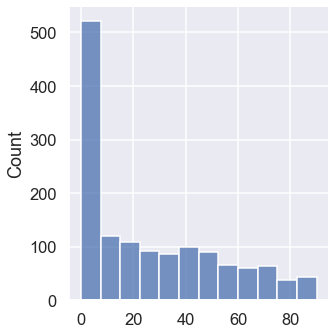

In [1327]:
# Distribution of mean minutes played, aggreagated by player
# lots of players where their *mean* over all games is less than 25 minutes
sns.displot(players.groupby('name')['minutes'].mean().values)

# How do we handle players with low minutes?
To implement: Try dropping players who played 0 minutes in the previous game (or who averaged less than 45 minutes in the past 3?)
Over two-thirds our players have averaged less than 50 minutes -- lets drop those players

In [1328]:
players.groupby('total_points')[['minutes_shift', 'minutes_shift_2', 'minutes_shift_3']].median()

,minutes_shift,minutes_shift_2,minutes_shift_3
total_points,,,
0,0.0,0.00,0.000000
1,60.0,45.00,49.000000
2,90.0,86.00,80.666667
3,90.0,84.50,80.666667
4,77.0,56.75,60.000000
5,90.0,84.50,78.666667
6,90.0,90.00,88.333333
7,90.0,90.00,83.000000
8,90.0,87.00,81.666667


<AxesSubplot:xlabel='total_points', ylabel='Count'>

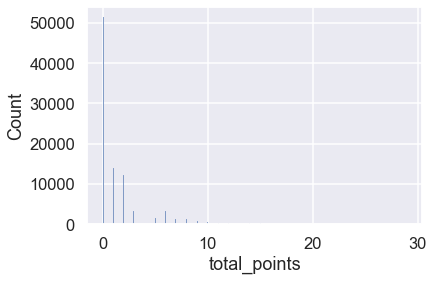

In [1329]:
sns.histplot(players.total_points)

In [1330]:
len(players)

91683

In [1331]:
players = players[players['minutes_shift_2'] > 45]

<AxesSubplot:xlabel='minutes_shift_2', ylabel='Count'>

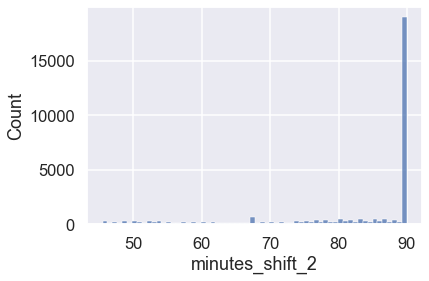

In [1332]:
sns.histplot(players.minutes_shift_2)

<AxesSubplot:xlabel='total_points', ylabel='Count'>

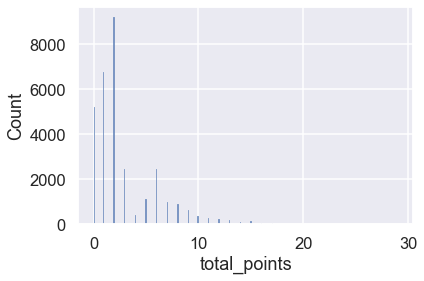

In [1333]:
sns.histplot(players.total_points)

In [1334]:
#Visualising numerical predictor variables with Target Variables

'''
players_num = players.select_dtypes(include=['int64','float64'])
fig,axs= plt.subplots(10,3,figsize=(20,80))
#adjust horizontal space between plots 
fig.subplots_adjust(hspace=0.6)
for i,ax in zip(players_num.columns,axs.flatten()):
    sns.regplot(x = i, y = 'total_points',data = players_num, ax = ax, color = 'b')
    plt.xlabel(i,fontsize=12)
    plt.ylabel('Total Points',fontsize=12)
    #ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('Total Points'+' - '+str(i),fontweight='bold',size=20)
'''

"\nplayers_num = players.select_dtypes(include=['int64','float64'])\nfig,axs= plt.subplots(10,3,figsize=(20,80))\n#adjust horizontal space between plots \nfig.subplots_adjust(hspace=0.6)\nfor i,ax in zip(players_num.columns,axs.flatten()):\n    sns.regplot(x = i, y = 'total_points',data = players_num, ax = ax, color = 'b')\n    plt.xlabel(i,fontsize=12)\n    plt.ylabel('Total Points',fontsize=12)\n    #ax.set_yticks(np.arange(0,900001,100000))\n    ax.set_title('Total Points'+' - '+str(i),fontweight='bold',size=20)\n"

In [1335]:
print("Skewness: %f" % players['total_points'].skew())
print("Kurtosis: %f" % players['total_points'].kurt())

Skewness: 1.824393
Kurtosis: 3.932783


<AxesSubplot:xlabel='total_points', ylabel='Count'>

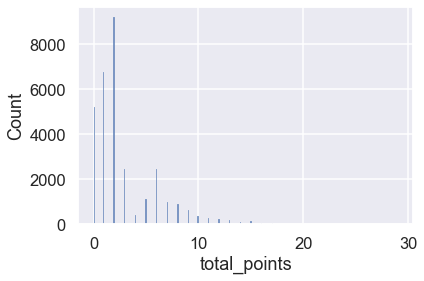

In [1336]:
sns.histplot(players.total_points)

In [1337]:
len(players[players.total_points > 15])

144

In [1338]:
len(players[players.total_points <= 1])

11949

In [1339]:
# a massive number of our players earning less than or equal to 1 
# point earned less than or equal to 2 in the game before
players[players.total_points <=1].groupby(['total_points_shift'])['was_home'].count()

total_points_shift
-6.0        1
-4.0        3
-3.0       16
-2.0       83
-1.0      139
 0.0      765
 1.0     3420
 2.0     3742
 3.0      836
 4.0      172
 5.0      420
 6.0     1040
 7.0      385
 8.0      299
 9.0      200
 10.0     102
 11.0      88
 12.0      73
 13.0      49
 14.0      38
 15.0      41
 16.0      17
 17.0      12
 18.0       2
 19.0       1
 20.0       1
 21.0       3
 24.0       1
Name: was_home, dtype: int64

In [1340]:
# players = players[players['total_points_shift'] > 1]

In [1341]:
# players.groupby('total_points')['was_home'].count()

In [1342]:
# players.loc[players.total_points > 14, 'total_points'] = players[players.total_points > 14]['total_points']-1

In [1343]:
# players.loc[players.total_points > 15, 'total_points'] = 15

In [1274]:
#Correlation between variables to check multicollinearity 
'''
# Generate a mask for the upper triangle (taken from seaborn example gallery)
plt.subplots(figsize = (30,20))
mask = np.zeros_like(players_num.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Plotting heatmap
sns.heatmap(players_num.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0)
'''

'\n# Generate a mask for the upper triangle (taken from seaborn example gallery)\nplt.subplots(figsize = (30,20))\nmask = np.zeros_like(players_num.corr(), dtype=np.bool)\nmask[np.triu_indices_from(mask)] = True\n#Plotting heatmap\nsns.heatmap(players_num.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0)\n'

# Begin ML Work

In [1368]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.compose import TransformedTargetRegressor

In [1369]:
feature_cols = ['position',
 'was_home',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp',
 'spi_d',
 'proj_score_d',
 'total_points_shift',
 'bps_shift',
 'creativity_shift',
 'ict_index_shift',
 'influence_shift',
 'threat_shift',
 'minutes_shift',
 'transfers_balance_shift',
 'total_points_shift_3',
 'bps_shift_3',
 'creativity_shift_3',
 'ict_index_shift_3',
 'influence_shift_3',
 'threat_shift_3',
 'total_points_shift_5',
 'bps_shift_5',
 'creativity_shift_5',
 'ict_index_shift_5',
 'influence_shift_5',
 'threat_shift_5',
 'total_points_shift_7',
 'bps_shift_7',
 'creativity_shift_7',
 'ict_index_shift_7',
 'influence_shift_7',
 'threat_shift_7',
 'total_points_shift_30',
 'bps_shift_30',
 'creativity_shift_30',
 'ict_index_shift_30',
 'influence_shift_30',
 'threat_shift_30',
 'minutes_shift_2',
 'transfers_balance_shift_2',
 'minutes_shift_3',
 'transfers_balance_shift_3',
 'minutes_shift_5',
 'transfers_balance_shift_5']

# Preprocessing


## compare classifiers

In [1370]:
features = players[feature_cols]
labels = players['total_points']

In [1371]:
features.dtypes

position                       int64
was_home                        bool
spi                          float64
spi_opp                      float64
proj_score                   float64
proj_score_opp               float64
prob_w                       float64
prob_l                       float64
probtie                      float64
importance                   float64
importance_opp               float64
spi_d                        float64
proj_score_d                 float64
total_points_shift           float64
bps_shift                    float64
creativity_shift             float64
ict_index_shift              float64
influence_shift              float64
threat_shift                 float64
minutes_shift                float64
transfers_balance_shift      float64
total_points_shift_3         float64
bps_shift_3                  float64
creativity_shift_3           float64
ict_index_shift_3            float64
influence_shift_3            float64
threat_shift_3               float64
t

In [1372]:
features = features.reset_index(drop=True)

In [1373]:
cat_cols = ['position']

In [1374]:
ohe = OneHotEncoder(sparse=False)

In [1375]:
encoded_columns = ohe.fit_transform(features[cat_cols])

In [1376]:
ohe_positions = pd.DataFrame(encoded_columns)

In [1377]:
features = pd.concat([features, ohe_positions], axis=1)

In [1378]:
features = features.drop(columns='position')

In [1379]:
scaler = MinMaxScaler()
X = scaler.fit_transform(features)
y = scaler.fit_transform(labels.values.reshape(-1,1))

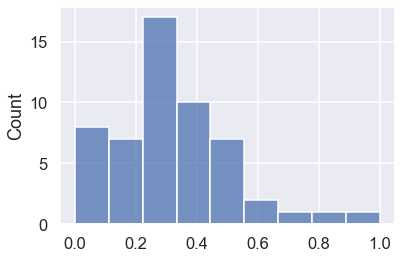

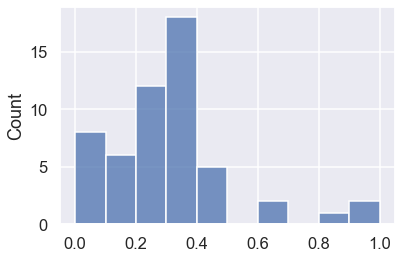

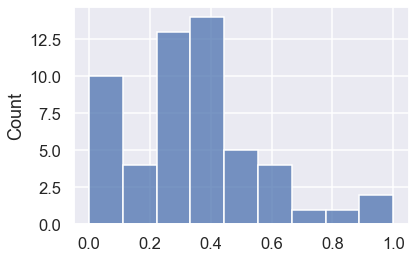

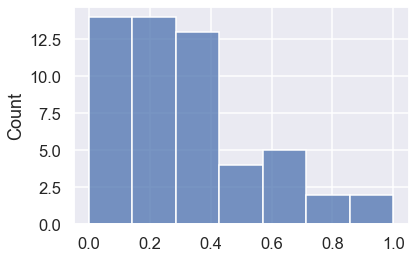

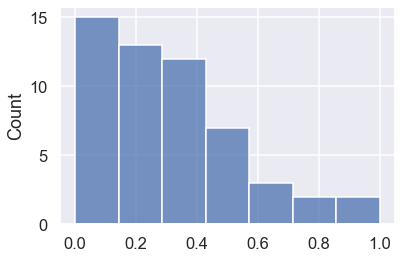

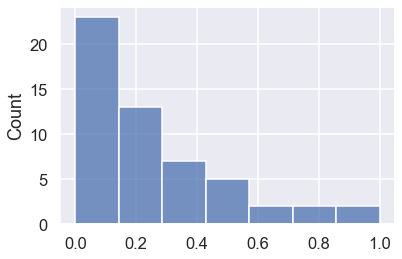

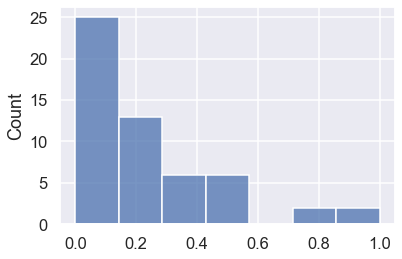

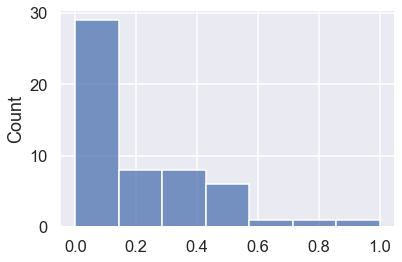

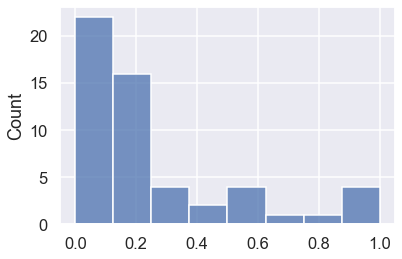

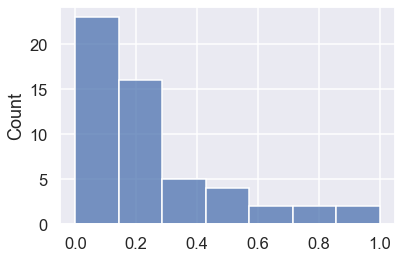

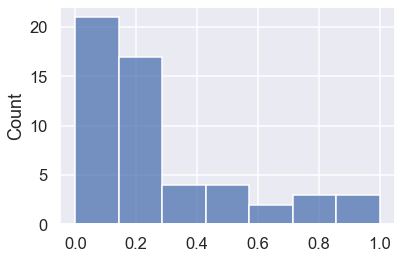

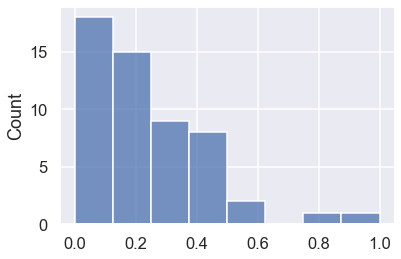

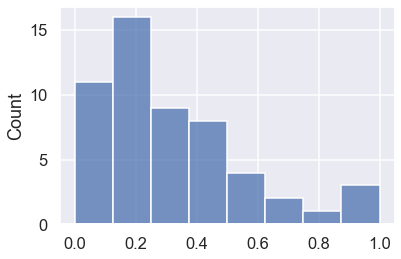

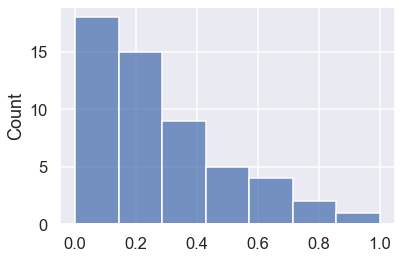

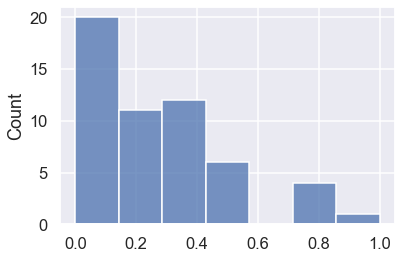

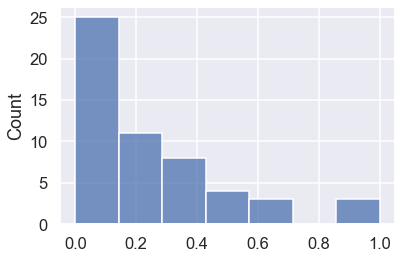

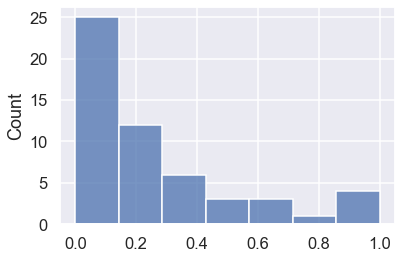

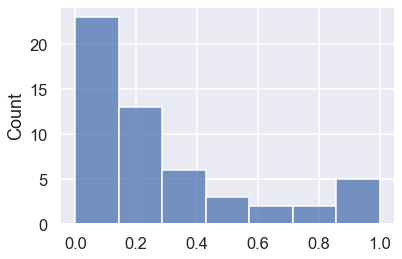

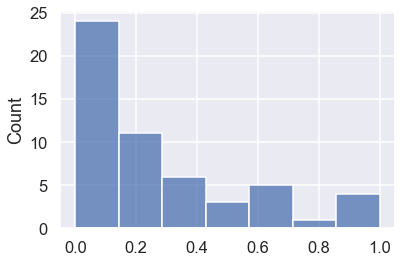

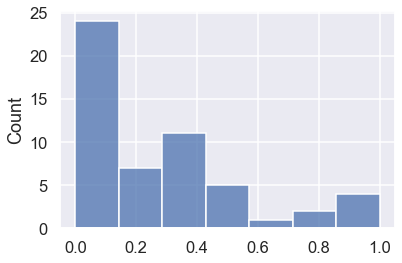

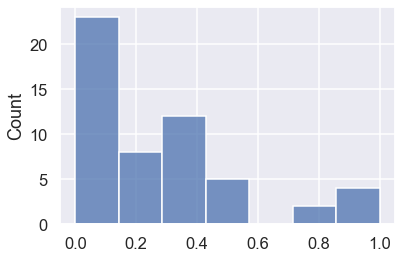

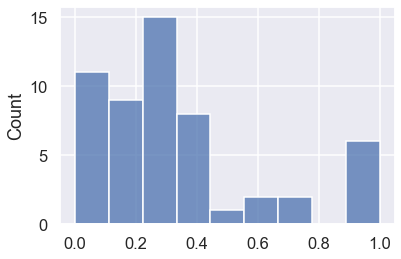

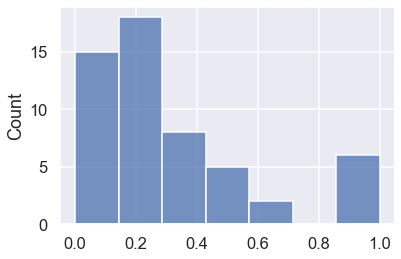

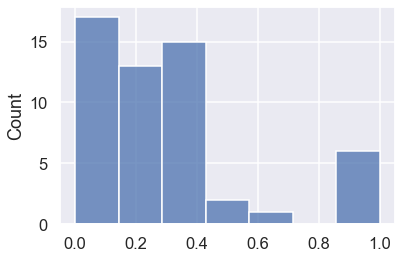

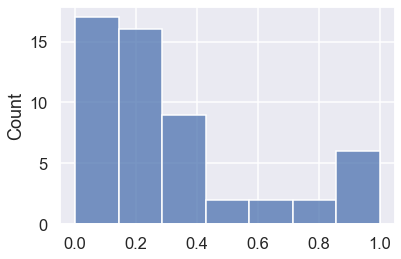

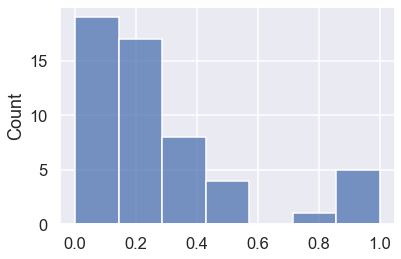

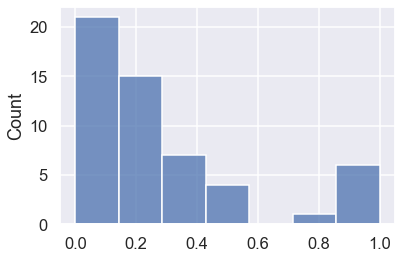

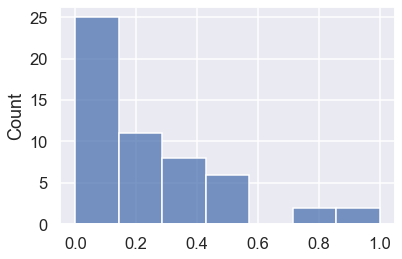

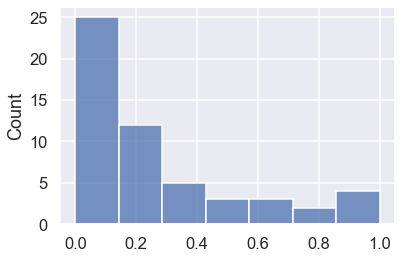

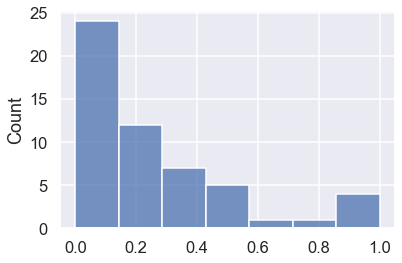

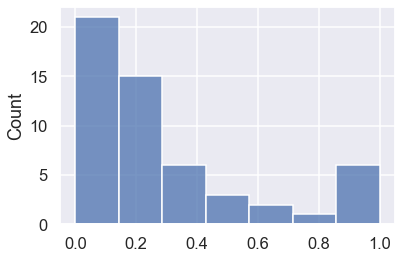

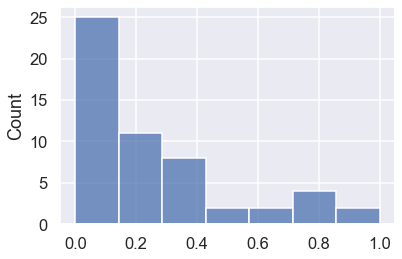

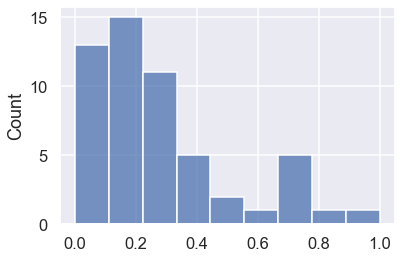

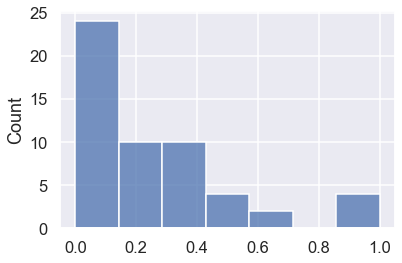

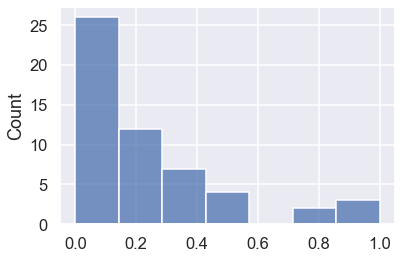

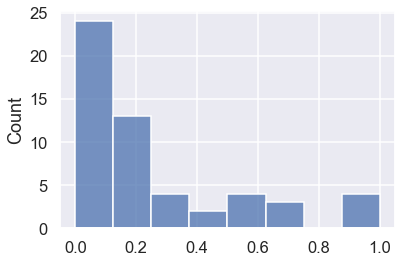

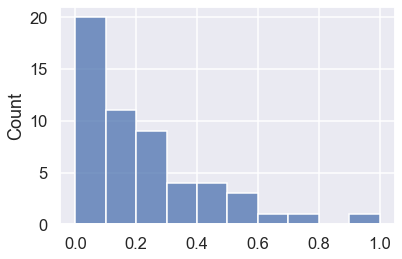

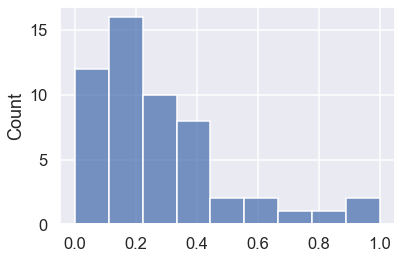

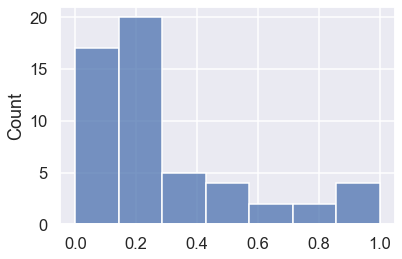

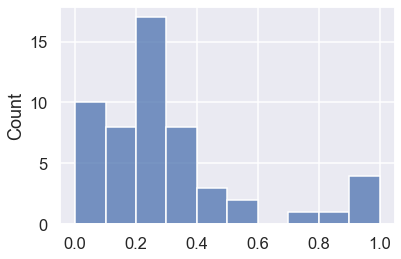

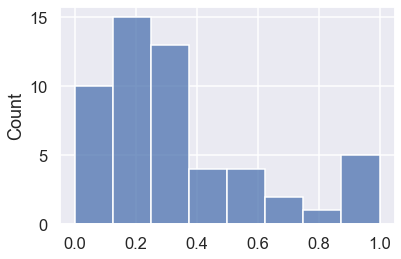

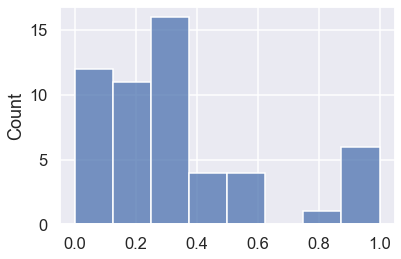

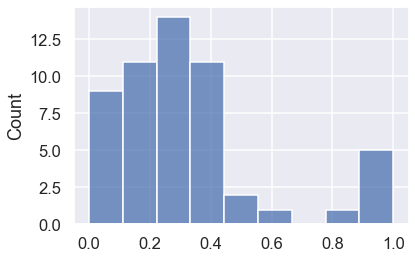

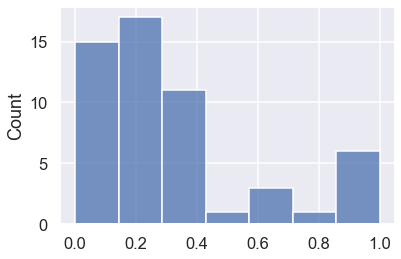

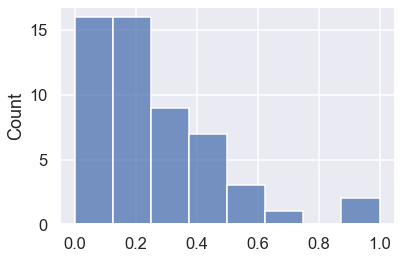

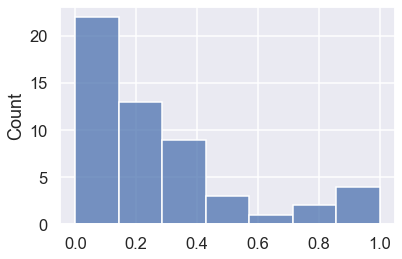

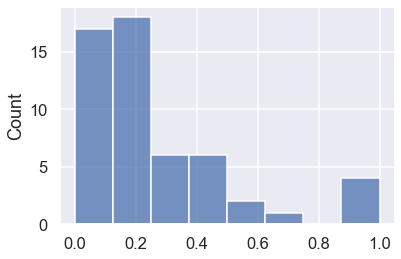

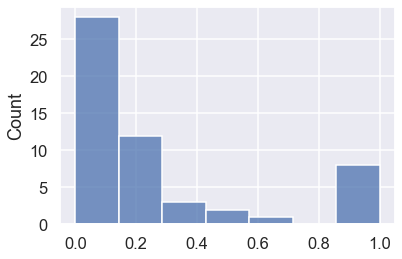

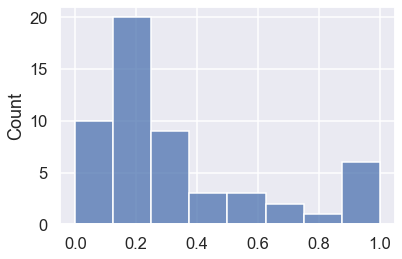

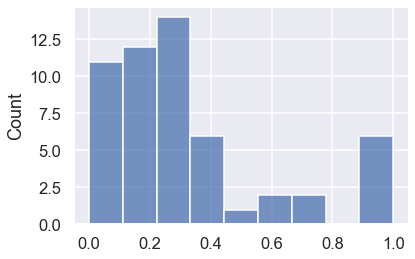

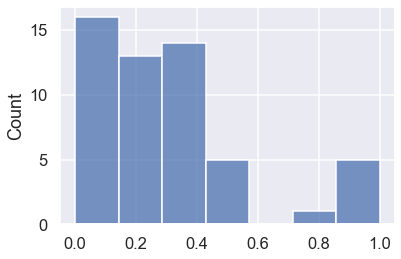

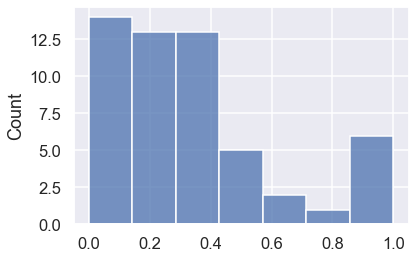

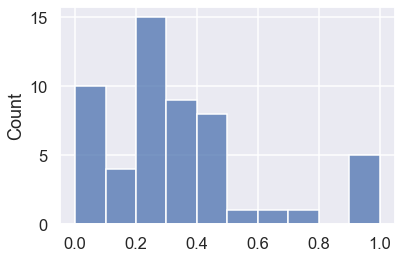

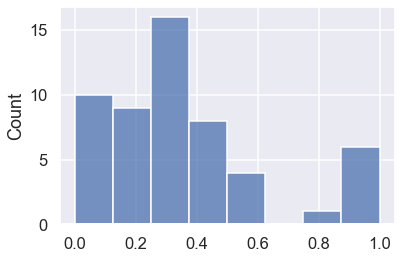

In [1380]:
for axis in np.arange(0,X.shape[1], 1):
    sns.histplot(X[axis])
    # sns.distplot(X[axis])
    plt.show()

<AxesSubplot:ylabel='Count'>

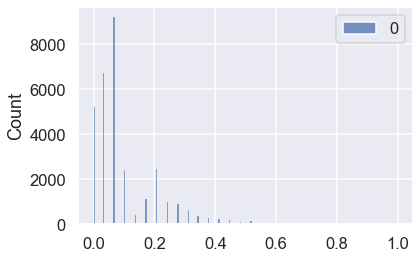

In [1381]:
sns.histplot(y)

In [1382]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
# models.append(('SGD', SGDRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
#models.append(('DTC', DecisionTreeClassifier()))
models.append(('Lasso', LassoCV()))
models.append(('Elastic Net', ElasticNetCV()))
models.append(('Ridge', RidgeCV()))
models.append(('Random Forest', RandomForestRegressor()))
# evaluate each model in turn

In [1383]:
import warnings
warnings.filterwarnings('ignore') 

#commenting out because i've already selected my model

'''
# evaluate each model in turn
features = features
labels = labels
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = -model_selection.cross_val_score(model, features, labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    predicted = cross_val_predict(model, features, labels, cv=kfold)
    #make scatterplot
    fig, ax = plt.subplots()
    sns.scatterplot(x=labels.ravel(), y=predicted.ravel())
    ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'k--', lw=4)
    fig.suptitle(name)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    dif = predicted.ravel() - labels.ravel()
    fig, ax = plt.subplots()
    sns.barplot(data = [dif[dif > 0], dif[dif < 0]])
    plt.show()
    # make heatmap
    # data = np.vstack((pd.cut(labels, bins=10, labels=np.arange(0,10,1)), pd.cut(predicted, bins=10, labels=np.arange(0,10,1)))).T
    # data = pd.DataFrame(data)
    # data['val'] = 'a'
    # data = data.groupby([0,1])['val'].count().reset_index()
    # data = data.pivot(index=0, columns=1, values='val').fillna(0)
    # sns.heatmap(data, vmin=0, vmax=5000)
    # plt.show()
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
'''

'\n# evaluate each model in turn\nfeatures = features\nlabels = labels\nresults = []\nnames = []\nscoring = \'neg_mean_absolute_error\'\nfor name, model in models:\n    kfold = model_selection.KFold(n_splits=10, random_state=seed)\n    cv_results = -model_selection.cross_val_score(model, features, labels, cv=kfold, scoring=scoring)\n    results.append(cv_results)\n    names.append(name)\n    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())\n    print(msg)\n    predicted = cross_val_predict(model, features, labels, cv=kfold)\n    #make scatterplot\n    fig, ax = plt.subplots()\n    sns.scatterplot(x=labels.ravel(), y=predicted.ravel())\n    ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], \'k--\', lw=4)\n    fig.suptitle(name)\n    ax.set_xlabel(\'Measured\')\n    ax.set_ylabel(\'Predicted\')\n    plt.show()\n    dif = predicted.ravel() - labels.ravel()\n    fig, ax = plt.subplots()\n    sns.barplot(data = [dif[dif > 0], dif[dif < 0]])\n    plt.show()

# Kfolds DTR

## settle on Decision Tree Regressor

In [1384]:
#clf = RandomForestRegressor()
clf = DecisionTreeRegressor()

In [1385]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)

scores = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scores.append(
        mean_squared_log_error(clf.fit(X_train, y_train).predict(X_test), y_test)
    )
    
np.mean(scores)

0.015483210654522406

In [1386]:
# save good classifiers for later :-)
#pickle.dump(clf, open('dtr-23-10-20', 'wb'))

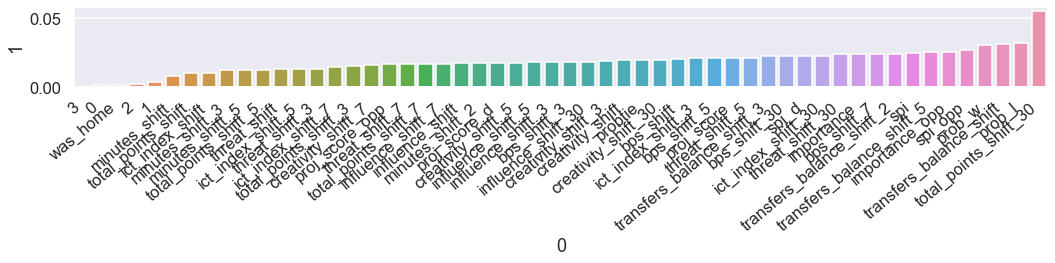

In [1387]:
## Look at feature importance in CLF

data = pd.DataFrame(zip(list(features), clf.feature_importances_))
data = data.sort_values(1)
plt.figure(figsize=(15,4))
ax = sns.barplot(x=0, y=1, data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [1389]:
players['clf_pred'] = scaler.inverse_transform(clf.predict(X).reshape(-1,1))
players['total_points'] = players.total_points.astype('float')

In [1390]:
abs(players['clf_pred'] - players['total_points']).mean()

0.7620970305843454

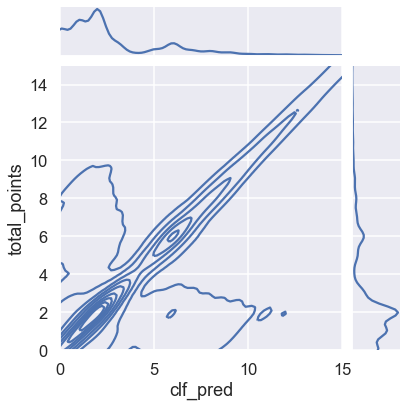

In [1391]:
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=players, x='clf_pred', y='total_points', kind='kde', xlim=(0,15), ylim=(0,15))

In [1392]:
players['mse'] = np.square(players.clf_pred - players.total_points)

In [1393]:
players.mse.mean()

4.956031029439817

4.936612021857924

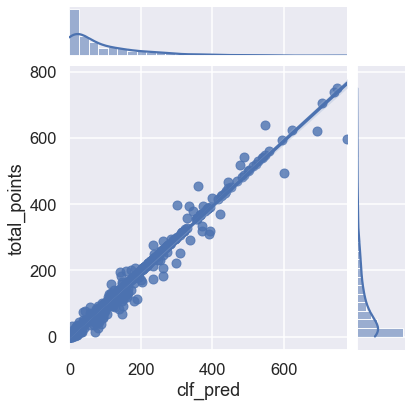

In [1394]:
data = players.groupby('name')[['total_points', 'clf_pred']].sum()
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='clf_pred', y='total_points', kind='reg')
mean_absolute_error(data.clf_pred, data.total_points)

10.902777777777779

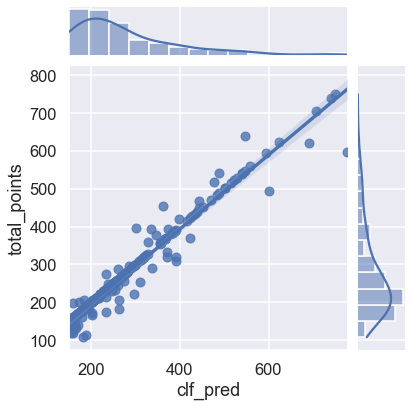

In [1395]:
# how does it perform on higher-quality players? pretty well!

data = data[data['clf_pred'] > 150]
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='clf_pred', y='total_points', kind='reg')
mean_absolute_error(data.clf_pred, data.total_points)

14.811208602122631

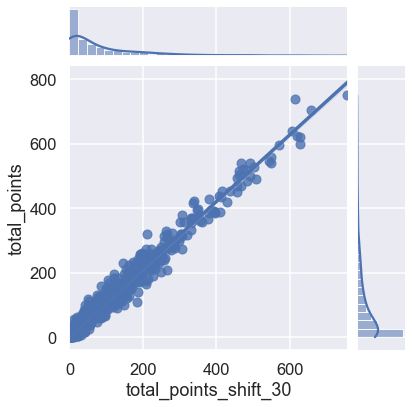

In [1396]:
#what would a season long estimate look like if we only used avg_points over the past 35 games as our indicator? not as good

data = players.groupby('name')[['total_points', 'total_points_shift_30']].sum()
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='total_points_shift_30', y='total_points', kind='reg')
mean_absolute_error(data.total_points_shift_30, data.total_points)

25.214303568952268

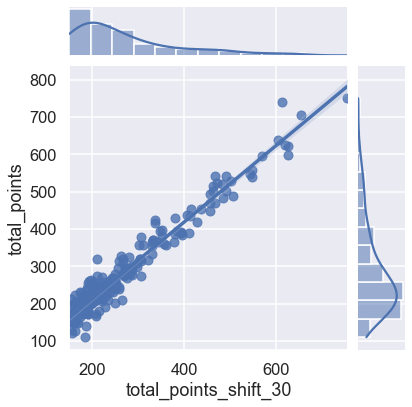

In [1397]:
# Does even worse on higher quality players

data = players.groupby('name')[['total_points', 'total_points_shift_30']].sum()
data = data[data['total_points_shift_30'] > 150]
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='total_points_shift_30', y='total_points', kind='reg')
mean_absolute_error(data.total_points_shift_30, data.total_points)

# Make Predictions for Unplayed Games

In [1398]:
last_gw = players.groupby(['season', 'gw'])['total_points'].count().reset_index()['gw'].tail(1).values

In [1399]:
last_gw = int(last_gw)

In [1400]:
last_results = players[(players.gw == last_gw) & (players.season == 2021)]

In [ ]:
#The teachnique will be to merge the last_results with the next 5 games for each player

In [1082]:
# add today's date -- only want to look at games in the SPI df after this date
today = '2020-10-20'

In [1402]:
spi_2020 = spi[(spi['date'] > today) & (spi['date'] < '2021-06-01')]

# add in any injuries & make sure prices are most current

In [1961]:
injuries = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/2020-21/soccer-injury-report.csv')

In [1962]:
list(injuries)

['Player', 'Team', 'Pos', 'Injury', 'Status', 'Est. Return']

# Solve Knapsack problem

In [1964]:
import pulp

In [1965]:
def select_team(expected_scores, prices, positions, clubs, total_budget=99.6, sub_factor=0.2):
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
    decisions = [
        pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    captain_decisions = [
        pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    sub_decisions = [
        pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]


    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve()
    print("Total expected score = {}".format(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [1966]:
#list of names that the model should not pick -- these might be known injuries, for example

do_not_pick = list(injuries.Player)

In [1967]:
do_not_pick.extend(['Tammy Abraham', 'Tariq Lamptey', 'Martin Dubravka', 
               'Kevin De Bruyne', 'Jamaal Lascelles', 'Raheem Sterling', 'Nicolás Otamendi',
              'Eric Garcia', 'Adrián Bernabé', 'João Pedro Cavaco Cancelo', 'Claudio Bravo', 
                    'Riyad Mahrez', 'Tommy Doyle', 'Cole Palmer', 'Ilkay Gündogan'])

In [1968]:
data = df.groupby(['name', 'element_type', 'team', 'value'])['clf_pred'].sum().reset_index()
data = data.drop(index=list(data[data.name.isin(do_not_pick)].index))
expected_scores = data.clf_pred.values
prices = data.value.values / 10
positions = data.element_type.values
clubs = data.team.values
names = data.name.values
decisions, captain_decisions, sub_decisions = select_team(expected_scores, prices, positions, clubs)

/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/pulp/pulp.py:1195: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 6479.6


In [1969]:
chosen_names = []
chosen_points = []
chosen_position = []
actual_points = []
chosen_price = []
for i in range(len(data)):
    if decisions[i].value() !=0:
        chosen_names.append(names[i])
        chosen_points.append(expected_scores[i])
        chosen_position.append(positions[i])
        chosen_price.append(prices[i])
chosen_ones = pd.DataFrame(zip(chosen_names, chosen_points, chosen_position, chosen_price), columns=['name', 'pred', 'pos', 'price'])

sub_names = []
sub_points = []
sub_position = []
actual_points = []
sub_price = []
for i in range(len(data)):
    if sub_decisions[i].value() !=0:
        sub_names.append(names[i])
        sub_points.append(expected_scores[i])
        sub_position.append(positions[i])
        sub_price.append(prices[i])
subs = pd.DataFrame(zip(sub_names, sub_points, sub_position, sub_price), columns= ['name', 'pred', 'pos', 'price'])

In [1970]:
df.groupby('name')['clf_pred'].mean().reset_index().sort_values('clf_pred', ascending=False)

,name,clf_pred
473,Ruben Loftus-Cheek,18.000000
349,Mamadou Sakho,15.657895
414,Neeskens Kebano,13.210526
195,Grady Diangana,13.184211
312,Kelland Watts,12.947368
...,...,...
179,Florian Lejeune,0.000000
178,Filip Krovinovic,0.000000
170,Fabricio Agosto Ramírez,0.000000
165,Fabian Delph,0.000000


In [1971]:
chosen_ones.sort_values('pos')

,name,pred,pos,price
9,Sam Johnstone,438.0,1,4.5
0,Darnell Furlong,438.0,2,4.5
2,Joe Bryan,444.0,2,4.9
3,Kelland Watts,492.0,2,4.0
4,Mamadou Sakho,595.0,2,4.5
7,Phil Jagielka,489.0,2,4.0
1,Grady Diangana,501.0,3,5.5
5,Neeskens Kebano,502.0,3,4.9
8,Ruben Loftus-Cheek,684.0,3,5.9
10,Tom Cairney,445.0,3,5.4


In [1909]:
subs.sort_values('pos')

,name,pred,pos,price
1,David de Gea,189.0,1,5.5
0,Ahmed El Mohamady,204.0,2,4.5
2,Jesse Lingard,217.0,3,5.9
3,William Smallbone,201.0,3,4.5


In [1910]:
chosen_ones.merge(players[players.name.isin(chosen_ones.name)].groupby('name')['total_points'].sum().reset_index(), on='name')

,name,pred,pos,price,total_points
0,Gabriel Fernando de Jesus,229.0,4,9.4,225.0
1,Harry Kane,217.0,4,10.5,318.0
2,Kasper Schmeichel,203.0,1,5.5,276.0
3,Mason Mount,222.0,3,6.9,137.0
4,Mohamed Salah,261.0,3,12.3,492.0
5,Neco Williams,219.0,2,4.0,14.0
6,Scott Dann,313.0,2,4.5,74.0
7,Virgil van Dijk,266.0,2,6.5,386.0
8,Willian Borges Da Silva,233.0,3,8.0,276.0


In [1914]:
subs.merge(players[players.name.isin(sub_names)].groupby('name')['total_points'].sum().reset_index(), on='name')

,name,pred,pos,price,total_points
0,Ahmed El Mohamady,204.0,2,4.5,39.0
1,David de Gea,189.0,1,5.5,143.0
2,Jesse Lingard,217.0,3,5.9,110.0
3,William Smallbone,201.0,3,4.5,24.0


In [1915]:
chosen_actual = season[season.name.isin(chosen_names)].groupby(['name', 'kickoff_time'])['total_points'].sum().reset_index()
chosen_actual.groupby('name')['total_points'].sum().reset_index()

,name,total_points
0,Gabriel Fernando de Jesus,6
1,Harry Kane,44
2,Kasper Schmeichel,12
3,Mason Mount,16
4,Mohamed Salah,41
5,Neco Williams,0
6,Patrick Bamford,30
7,Scott Dann,7
8,Thiago Thiago,7
9,Virgil van Dijk,14


In [1913]:
chosen_actual.total_points.sum()

197

In [970]:
df[df.name.isin(chosen_names)].groupby('name')['clf_pred'].sum().sort_values()

name
Rob Holding          163.666667
Adam Webster         165.500000
Virgil van Dijk      184.500000
Zack Steffen         190.000000
Kelechi Iheanacho    198.000000
Jack Grealish        211.500000
Timo Werner          216.000000
Phil Foden           227.000000
Sadio Mané           254.000000
Raúl Jiménez         258.500000
Mohamed Salah        304.000000
Name: clf_pred, dtype: float64

In [1923]:
df[df.name == 'Jack Grealish'].sort_values('date')

,name,element_type,team,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,season,played_more_than_20,was_home,spi_d,proj_score_d,minutes,total_points,avg_points_3,std_points_3,avg_points_7,std_points_7,avg_points_35,std_points_35,avg_mins_3,std_mins_3,avg_mins_7,std_mins_7,clf_pred
1903,Jack Grealish,3,Aston Villa,71,2020-09-21,Sheffield United,66.48,68.43,1.29,1.08,0.4085,0.3070,0.2844,35.1,34.2,2020,1,True,-1.95,0.21,90,3,5.333333,3.399346,3.571429,2.718043,3.942857,3.593191,90.0,0.0,90.0,0.0,2.0
1905,Jack Grealish,3,Aston Villa,71,2020-09-28,Fulham,67.61,61.80,1.24,1.29,0.3521,0.3730,0.2748,32.9,42.4,2020,1,True,5.81,-0.05,90,8,5.666667,3.091206,3.714286,2.657296,4.000000,3.561701,90.0,0.0,90.0,0.0,2.0
1904,Jack Grealish,3,Aston Villa,71,2020-10-04,Liverpool,69.04,91.44,0.85,2.33,0.1201,0.7000,0.1800,20.9,79.6,2020,1,True,-22.40,-1.48,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,2.0
17391,Jack Grealish,3,Aston Villa,71,2020-10-18,Leicester,72.43,79.83,1.11,1.83,0.2279,0.5367,0.2354,31.6,49.2,2020,1,True,-7.40,-0.72,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,5.0
17374,Jack Grealish,3,Aston Villa,71,2020-10-23,Leeds United,72.43,65.87,1.74,1.16,0.5047,0.2526,0.2427,31.6,49.2,2020,1,True,6.56,0.58,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,10.0
17375,Jack Grealish,3,Aston Villa,71,2020-11-01,Southampton,72.43,72.31,1.53,1.25,0.4350,0.3076,0.2574,31.6,49.2,2020,1,True,0.12,0.28,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,10.0
17392,Jack Grealish,3,Aston Villa,71,2020-11-07,Arsenal,72.43,78.56,1.17,1.74,0.2543,0.5029,0.2428,31.6,49.2,2020,1,True,-6.13,-0.57,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,5.0
17376,Jack Grealish,3,Aston Villa,71,2020-11-21,Brighton,72.43,70.38,1.61,1.25,0.4553,0.2930,0.2517,31.6,49.2,2020,1,True,2.05,0.36,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,10.0
17393,Jack Grealish,3,Aston Villa,71,2020-11-28,West Ham,72.43,73.65,1.33,1.65,0.3066,0.4464,0.2469,31.6,49.2,2020,1,True,-1.22,-0.32,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,2.0
17377,Jack Grealish,3,Aston Villa,71,2020-12-05,Newcastle,72.43,65.22,1.67,1.04,0.5169,0.2340,0.2491,31.6,49.2,2020,1,True,7.21,0.63,90,24,7.000000,2.943920,4.571429,2.920721,4.171429,3.605438,90.0,0.0,90.0,0.0,5.0


In [971]:
players[players.name.isin(chosen_names)].groupby(['name', 'season'])['total_points'].sum().reset_index()

,name,season,total_points
0,Adam Webster,2019,88.0
1,Jack Grealish,2019,149.0
2,Kelechi Iheanacho,2018,58.0
3,Kelechi Iheanacho,2019,64.0
4,Mohamed Salah,2018,259.0
5,Mohamed Salah,2019,233.0
6,Phil Foden,2018,25.0
7,Phil Foden,2019,69.0
8,Raúl Jiménez,2018,181.0
9,Raúl Jiménez,2019,194.0


## Changes to Implement
- Feature engineering: add short term points average (maybe past 3 games), med-term (maybe past 7), and last-season average, standard deviation of points earned over past three games
- Feature engineering: add minutes played per game over past 3 games, past 7 games, standard deviation of minutes played over past 3 games
- 'remove played_over_20_minutes' column. It's non-historical data -- I only know the answer after the game, and it's overly emphasized in the current model
- chart accuracy of prediction over time


In [1230]:
test = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/gws/merged_gw.csv')

In [1231]:
test

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Aaron_Cresswell_376,0,0,7,0,1.5,376,8,5,0,1.1,9.0,2019-08-10T11:30:00Z,90,11,0,0,0,0,1,0,23399,5.0,0.0,0.0,0,0,0,0,50,True,0,1
1,Aaron_Lennon_430,0,0,3,0,0.0,430,3,0,0,0.2,2.0,2019-08-10T14:00:00Z,6,16,0,0,0,0,1,0,8105,0.0,3.0,0.0,1,0,0,0,50,True,0,1
2,Aaron_Mooy_516,0,0,0,0,0.0,516,7,0,0,0.0,0.0,2019-08-10T14:00:00Z,0,18,0,0,0,0,1,0,16261,3.0,0.0,0.0,0,0,0,0,50,False,0,1
3,Aaron_Ramsdale_494,0,0,11,0,0.0,494,2,1,0,1.0,9.8,2019-08-10T14:00:00Z,90,15,0,0,0,0,1,2,3091,1.0,1.0,0.0,2,0,0,0,45,True,0,1
4,Aaron_Wan-Bissaka_122,0,2,34,1,16.1,122,9,0,0,4.9,30.4,2019-08-11T15:30:00Z,90,6,0,0,0,0,1,0,1879259,0.0,4.0,2.0,8,0,0,0,55,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22555,Youri_Tielemans_448,0,0,11,0,37.4,448,376,1,0,6.9,12.6,2020-07-26T15:00:00Z,72,12,0,0,0,0,47,0,283764,2.0,0.0,19.0,2,-3103,1905,5008,61,True,0,47
22556,Yves_Bissouma_53,0,0,22,0,1.3,53,372,1,1,4.8,39.2,2020-07-26T15:00:00Z,72,5,0,0,0,0,47,0,2136,2.0,1.0,7.0,7,77,147,70,50,False,0,47
22557,Zech_Medley_636,0,0,0,0,0.0,636,371,0,0,0.0,0.0,2020-07-26T15:00:00Z,0,18,0,0,0,0,47,0,2496,2.0,3.0,0.0,0,153,325,172,40,True,0,47
22558,Çaglar_Söyüncü_164,0,0,0,0,0.0,164,376,0,0,0.0,0.0,2020-07-26T15:00:00Z,0,12,0,0,0,0,47,0,688011,2.0,0.0,0.0,0,-95515,165,95680,49,True,0,47


In [1105]:
players[(players.position == 1) & (players.season == 2021)].groupby('name')[['total_points', 'clf_pred']].mean()

KeyError: "Columns not found: 'clf_pred'"